## Oregon inshore mooring - 2019 upwelling season

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from matplotlib.colors import LinearSegmentedColormap
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
from physoce import tseries as ts

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


### ADCP data

Bottom mounted Acoustic Doppler Current Profiler

* [View in data explorer](https://dataexplorer.oceanobservatories.org/?ls=rPOncp95#metadata/103699/station/83/sensor/data?start=2014-04-18T00:21:00Z&end=2021-04-01T06:33:00Z&leg_clim_max=false&leg_clim_min=false)

In [2]:
ncfile_adcp = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds_adcp = xr.open_dataset(ncfile_adcp+'#fillmismatch')

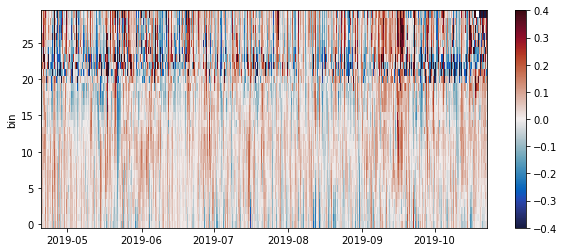

In [5]:
plt.figure(figsize=(10,4))
plt.pcolor(ds_adcp['time'],ds_adcp['bin'],
           ds_adcp['eastward_seawater_velocity'].T,
           shading='auto',
           cmap=cm.balance)
plt.ylabel('bin')
plt.clim([-0.4,0.4])
plt.colorbar()

### Profiler data

Using the nitrate sensor data set, which also contains the temperature and salinity data from the CTD. There is a nitrate variable that includes corrections for temperature and salinity, but that has some large outliers. The plots below use the uncorrected nitrate for visualization.

* [View on data explorer](https://dataexplorer.oceanobservatories.org/?ls=dtMqfXYP#metadata/103717/station/124/sensor/data?start=2019-04-09T15:12:47Z&end=2019-10-05T01:20:01Z&leg_clim_max=false&leg_clim_min=false)

#### Note on accessing data from the OOI Data Explorer tool

* Click on the link above
* Above the plot, click "All downloads"
* This brings up a page that lists the deployment numbers with their date ranges
* For one of the individual deployments click the green downloads button
* Next to THREDDS catalog, click the green downloads button
* The catalog has files from every deployment. For each deployment, there are .ncml files that contain all of the data
* Click on the ncml file for the deployment and instrument you want (in this case: `deployment0013_CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered.ncml`)
* Click on OpenDAP
* The link in the Data Url box can be used by xarray (see code cell below)

In [6]:
ncfile_prof = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered/deployment0013_CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered.ncml'
ds_no3 = xr.open_dataset(ncfile_prof+'#fillmismatch')

Text(0.5, 1.0, 'uncorrected nitrate [$\\mu$M]')

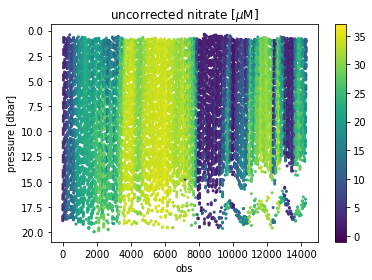

In [9]:
plt.figure()
plt.scatter(ds_no3['obs'],ds_no3['pressure'],4,ds_no3['nitrate_concentration'])
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylabel('pressure [dbar]')
plt.xlabel('obs')
plt.title('uncorrected nitrate [$\mu$M]')

Text(0.5, 1.0, 'temperature [deg C]')

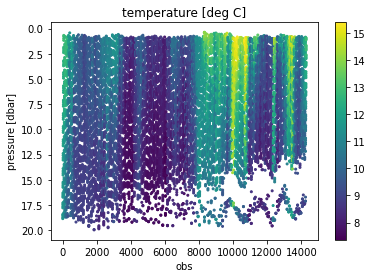

In [10]:
plt.figure()
plt.scatter(ds_no3['obs'],ds_no3['pressure'],4,ds_no3['temperature'])
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylabel('pressure [dbar]')
plt.xlabel('obs')
plt.title('temperature [deg C]')

Text(0.5, 1.0, 'practical salinity')

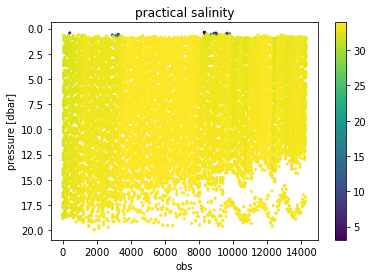

In [11]:
plt.figure()
plt.scatter(ds_no3['obs'],ds_no3['pressure'],4,ds_no3['salinity'])
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylabel('pressure [dbar]')
plt.xlabel('obs')
plt.title('practical salinity')

Text(0, 0.5, 'uncorrected nitrate [$\\mu$M]')

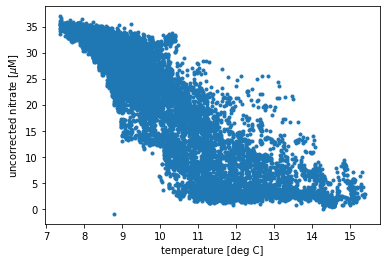

In [12]:
plt.figure()
plt.plot(ds_no3['temperature'],ds_no3['nitrate_concentration'],'.')
plt.xlabel('temperature [deg C]')
plt.ylabel('uncorrected nitrate [$\mu$M]')

Text(0, 0.5, 'temperature [deg C]')

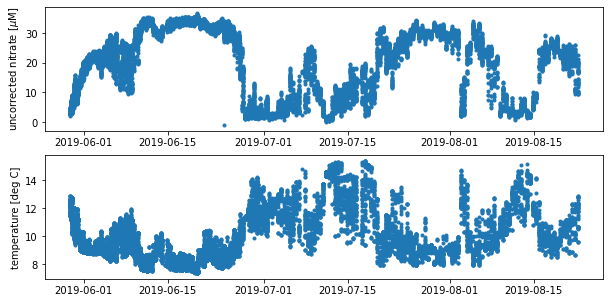

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(ds_no3['time'],ds_no3['nitrate_concentration'],'.')
plt.ylabel('uncorrected nitrate [$\mu$M]')
plt.subplot(2,1,2)
plt.plot(ds_no3['time'],ds_no3['temperature'],'.')
plt.ylabel('temperature [deg C]')

In [14]:
ds_no3 = ds_no3.swap_dims({'obs':'time'})

In [16]:
dt_str = '1D'  # string indicating time averaging frequency
dt = pd.to_timedelta(dt_str)   # time averaging frequency as timedelta
tmin = ds_no3['time'][0].dt.round(dt_str)    # round start date
tmax = ds_no3['time'][-1].dt.round(dt_str)   # round end date
time_grid = np.array(pd.date_range(tmin.values,tmax.values,freq=dt_str))   # array of dates

In [17]:
pmin = 0  # minimum pressure
pmax = np.max(ds_no3['pressure'])   # maximum pressure
dp = 1   # pressure averaging interval
pressure_bins = np.arange(pmin,pmax+dp,dp)  # edges of pressure bins
pressure_grid = np.arange(pmin+dp/2,pmax,dp) # center of pressure bins

In [18]:
# pre-allocate gridded variable with NaNs
temperature_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)-1])
nitrate_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)-1])

In [19]:
for i,t in enumerate(time_grid):
    # find dates that fall in interval
    ti, = np.where((ds_no3['time'] >= t - dt/2) & (ds_no3['time'] < t + dt/2))
    try:
        temperature_subset = ds_no3['temperature'].isel(time=ti) 
        temperature_binned = temperature_subset.groupby_bins('pressure',pressure_grid).mean() # mean in pressure bins
        temperature_grid[i,:] = temperature_binned
        nitrate_subset = ds_no3['nitrate_concentration'].isel(time=ti)
        nitrate_binned = nitrate_subset.groupby_bins('pressure',pressure_grid).mean()
        nitrate_grid[i,:] = nitrate_binned
    except:
        #leave as NaN for this time range if no data
        pass

Text(0, 0.5, 'temperature [deg C]')

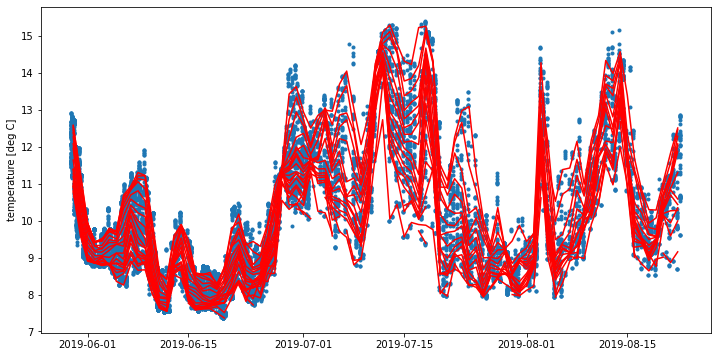

In [20]:
plt.figure(figsize=(12,6))
plt.plot(ds_no3['time'],ds_no3['temperature'],'.')
plt.plot(time_grid,temperature_grid,color='red');
plt.ylabel('temperature [deg C]')

Text(0, 0.5, 'nitrate [$\\mu mol/L$]')

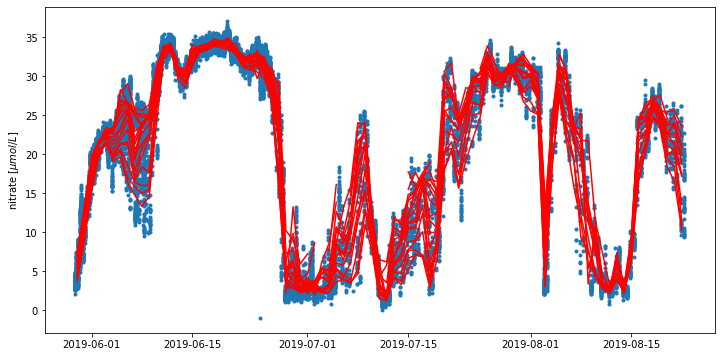

In [21]:
plt.figure(figsize=(12,6))
plt.plot(ds_no3['time'],ds_no3['nitrate_concentration'],'.')
plt.plot(time_grid,nitrate_grid,color='red');
plt.ylabel('nitrate [$\mu mol/L$]')

(18048.0, 18123.0)

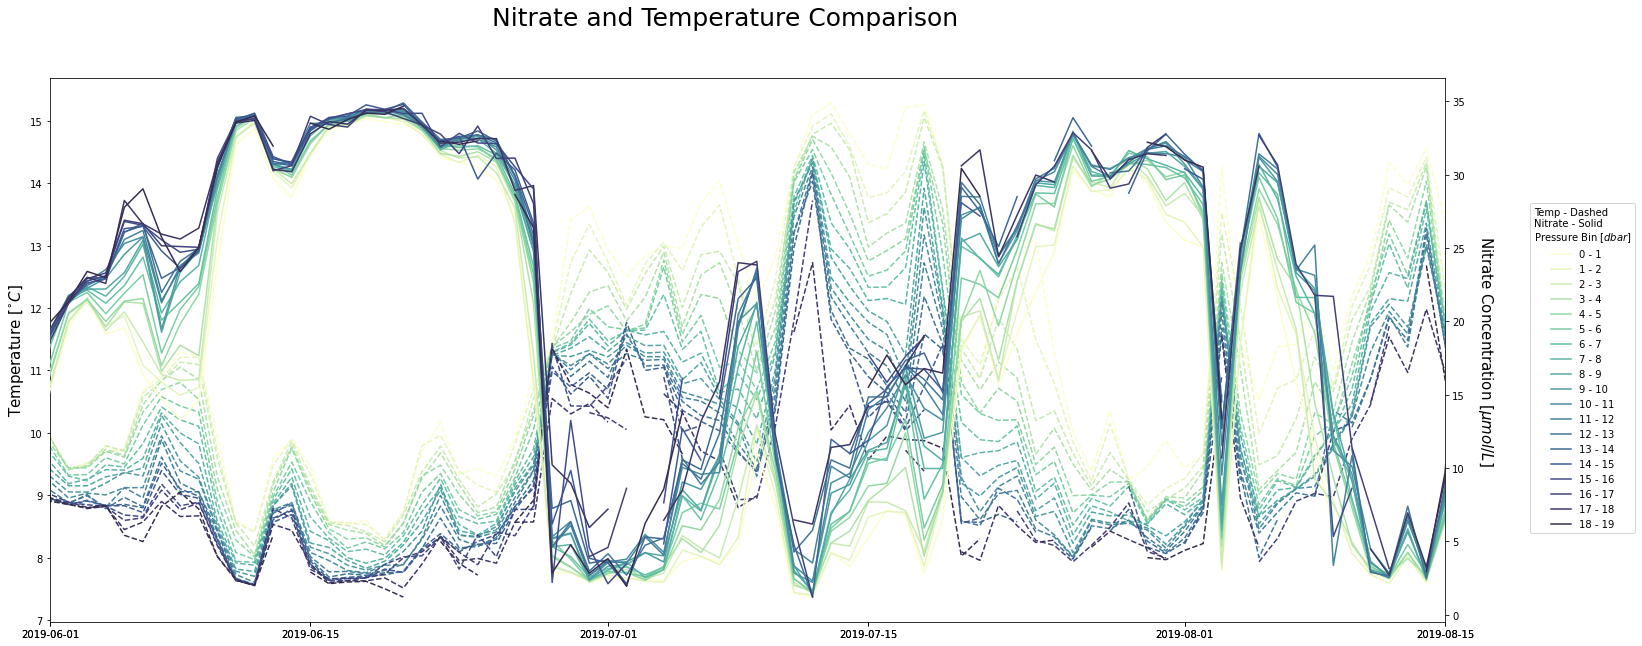

In [23]:
t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-15 00:00:00')

cdict = cm.tools.get_dict(cm.deep, N=len(nitrate_grid.T))
deep = LinearSegmentedColormap('cmap', cdict)

fig = plt.figure(figsize=(25,10))
fig.suptitle('Nitrate and Temperature Comparison', fontsize=25)
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Temperature [$^{\circ}C$]", fontsize=15)
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.set_ylabel("Nitrate Concentration [$\mu mol/L$]", rotation=270, labelpad=30, fontsize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

templine = []
nitrline = []
handles = []
labels = []

for i in range(len(temperature_grid.T)):
    templine.append('')
    templine[i], = ax1.plot(time_grid, temperature_grid.T[i], color=deep(i/20),
                             linestyle='--', label='%i - %i' %(pressure_bins[i], pressure_bins[i+1]))
for i in range(len(nitrate_grid.T)):   
    nitrline.append('')
    nitrline[i], = ax2.plot(time_grid, nitrate_grid.T[i], color=deep(i/20), 
                            linestyle='-', label='%i - %i' %(pressure_bins[i], pressure_bins[i+1]))


plt.legend(handles=nitrline, title='Temp - Dashed\nNitrate - Solid\nPressure Bin [$dbar$]', bbox_to_anchor=(1.14,.78), loc=1)
plt.xlim([t1,t2])

Redoing the analysis found in https://github.com/ascherer97/REU21/blob/main/inshore_adcp_analysis.ipynb so that we can compare wind and water velocities with temperature and nitrate

In [24]:
ds_adcp['u'] = ds_adcp['eastward_seawater_velocity']
ds_adcp['u'].attrs['units'] = 'm/s'

ds_adcp['v'] = ds_adcp['northward_seawater_velocity']
ds_adcp['v'].attrs['units'] = 'm/s'

#go from bins to depths
ds_adcp['bin_height'] = ds_adcp['depth_from_pressure'][0] - ds_adcp['bin_depths'][0,:]
ds_adcp['bin_height'].attrs['units'] = 'm'

ds_adcp['bin_depths_avg'] = ds_adcp['bin_height']-np.mean(ds_adcp['depth_from_pressure'])
ds_adcp['bin_depths_avg'].attrs['units'] = 'm'

ds_adcp['sea_surface'] = ds_adcp['depth_from_pressure']-np.mean(ds_adcp['depth_from_pressure'])
ds_adcp['sea_surface'].attrs['units'] = 'm'

ds_adcp['bottom_depth_avg'] = np.mean(ds_adcp['depth_from_pressure'])
ds_adcp['bottom_depth_avg'].attrs['units'] = 'm'

good = (ds_adcp['bin_depths'] > 3)

temp = xr.DataArray(ts.pl64(ds_adcp['u'],0.5),coords=(ds_adcp['obs'],ds_adcp['bin']),dims=('obs','bin'),
                    name='u_fil')
ds_adcp = ds_adcp.merge(temp)
temp = xr.DataArray(ts.pl64(ds_adcp['v'],0.5),coords=(ds_adcp['obs'],ds_adcp['bin']),dims=('obs','bin'),
                    name='v_fil')
ds_adcp = ds_adcp.merge(temp)

uda = ts.depthavg(ds_adcp['u_fil'].where(good),
                  ds_adcp['bin_depths_avg'],
                  ds_adcp['bottom_depth_avg'],
                  ds_adcp['sea_surface'])

vda = ts.depthavg(ds_adcp['v_fil'].where(good),
                  ds_adcp['bin_depths_avg'],
                  ds_adcp['bottom_depth_avg'],
                  ds_adcp['sea_surface'])

ds_adcp['uda'] = xr.DataArray(uda,dims='obs')
ds_adcp['uda'].attrs['units'] = 'm/s'
ds_adcp['vda'] = xr.DataArray(vda,dims='obs')
ds_adcp['vda'].attrs['units'] = 'm/s'

theta,major,minor = princax(ds_adcp['uda'],ds_adcp['vda'])
ds_adcp['cs_da'],ds_adcp['as_da'] = rot(ds_adcp['uda'],ds_adcp['vda'],-theta+90)
ds_adcp['cs_fil'],ds_adcp['as_fil'] = rot(ds_adcp['u_fil'],ds_adcp['v_fil'],-theta+90)
ds_adcp['cs_bar'] = ds_adcp['cs_fil'] - ds_adcp['cs_da']

Now to plot comparisons of velocity and Nitrate/temp:
* The velocity was only plotted at "representative" depths as plotting all the depth bins would make the graph impossible to read.
* The velocity depth measurements are given as meters underneath the sea surface, with the down direction being positive (i.e., depth increases to more positive values as you go down). 
* The axes are scaled to make viewing and comparison easier, but does decrease the resolution a bit
* Velocity measurements come from the sea bottom adcp profiler, but nitrate/depth come from profiler, which may introduce some discrepancy in depth measurements. Possibly worth taking velocity from profiler for more direct comparison, but that will take more work than I can do before next meeting 

In [25]:
zeros = np.zeros(len(ds_adcp['time']))

(-0.25, 0.1)

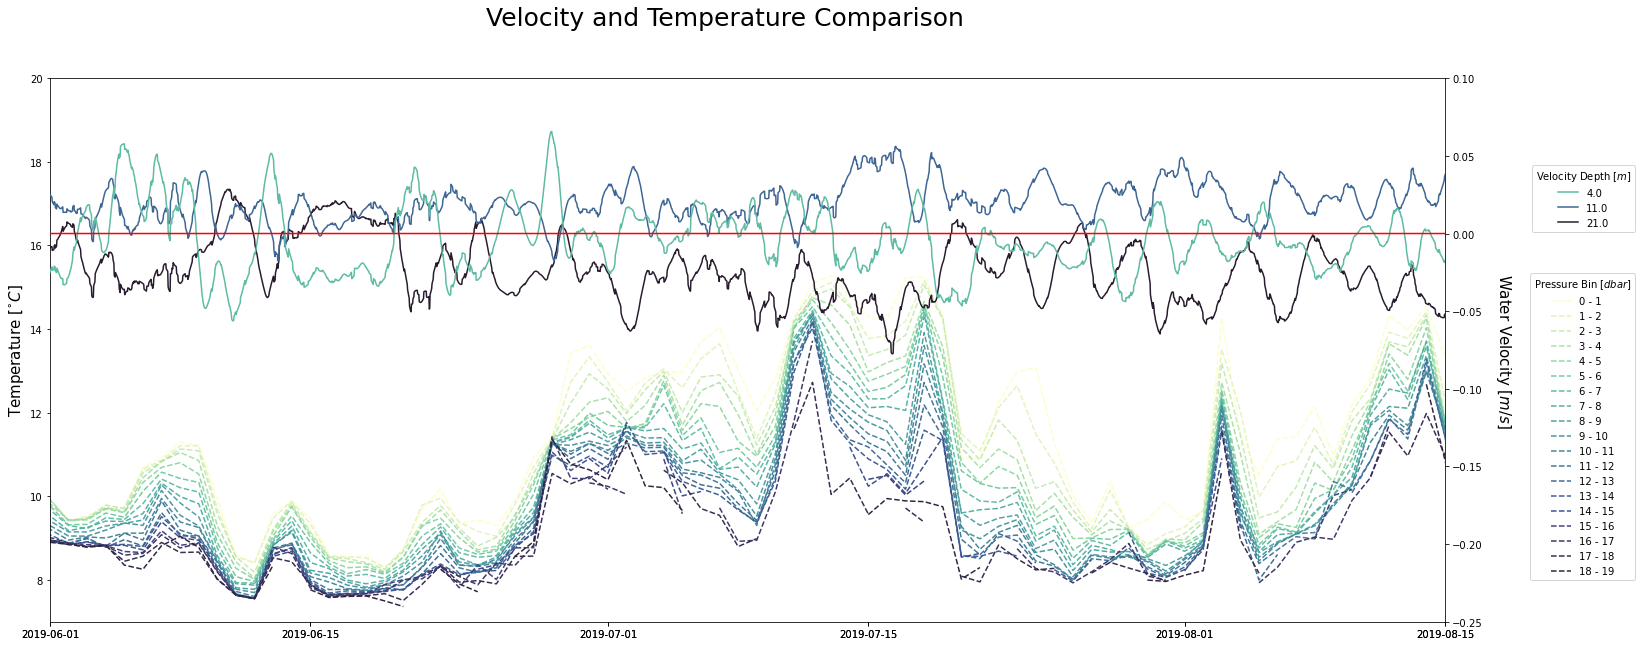

In [29]:
fig = plt.figure(figsize=(25,10))
fig.suptitle('Velocity and Temperature Comparison', fontsize=25)
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Temperature [$^{\circ}C$]", fontsize=15)
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.set_ylabel("Water Velocity [$m/s$]", rotation=270, labelpad=30, fontsize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

templine = []
nitrline = []

for i in range(len(temperature_grid.T)):
    templine.append('')
    templine[i], = ax1.plot(time_grid, temperature_grid.T[i], color=deep(i/len(temperature_grid.T)),
                             linestyle='--', label='%i - %i' %(pressure_bins[i], pressure_bins[i+1]))

veloline1, = ax2.plot(ds_adcp['time'], ds_adcp['cs_bar'].T[1], color=deep(0.99),
                      label='%.1f' %(-ds_adcp['bin_depths_avg'].values[1]))
veloline2, = ax2.plot(ds_adcp['time'], ds_adcp['cs_bar'].T[11], color=deep(0.66),
                     label='%.1f' %(-ds_adcp['bin_depths_avg'].values[11]))
veloline3, = ax2.plot(ds_adcp['time'], ds_adcp['cs_bar'].T[18], color=deep(0.33),
                     label='%.1f' %(-ds_adcp['bin_depths_avg'].values[18]))
velozero, = ax2.plot(ds_adcp['time'], zeros, color='r')


handle = [veloline3, veloline2, veloline1]
lgd1 = plt.legend(handles=templine, title='Pressure Bin [$dbar$]', bbox_to_anchor=(1.14,.65), loc=1)
lgd2 = plt.legend(handles=handle, title='Velocity Depth [$m$]', bbox_to_anchor=(1.14,.85), loc=1)
fig.add_artist(lgd1, lgd2)
plt.xlim([t1,t2])
ax1.set_ylim([7,20])
ax2.set_ylim([-0.25,0.1])

(-0.25, 0.1)

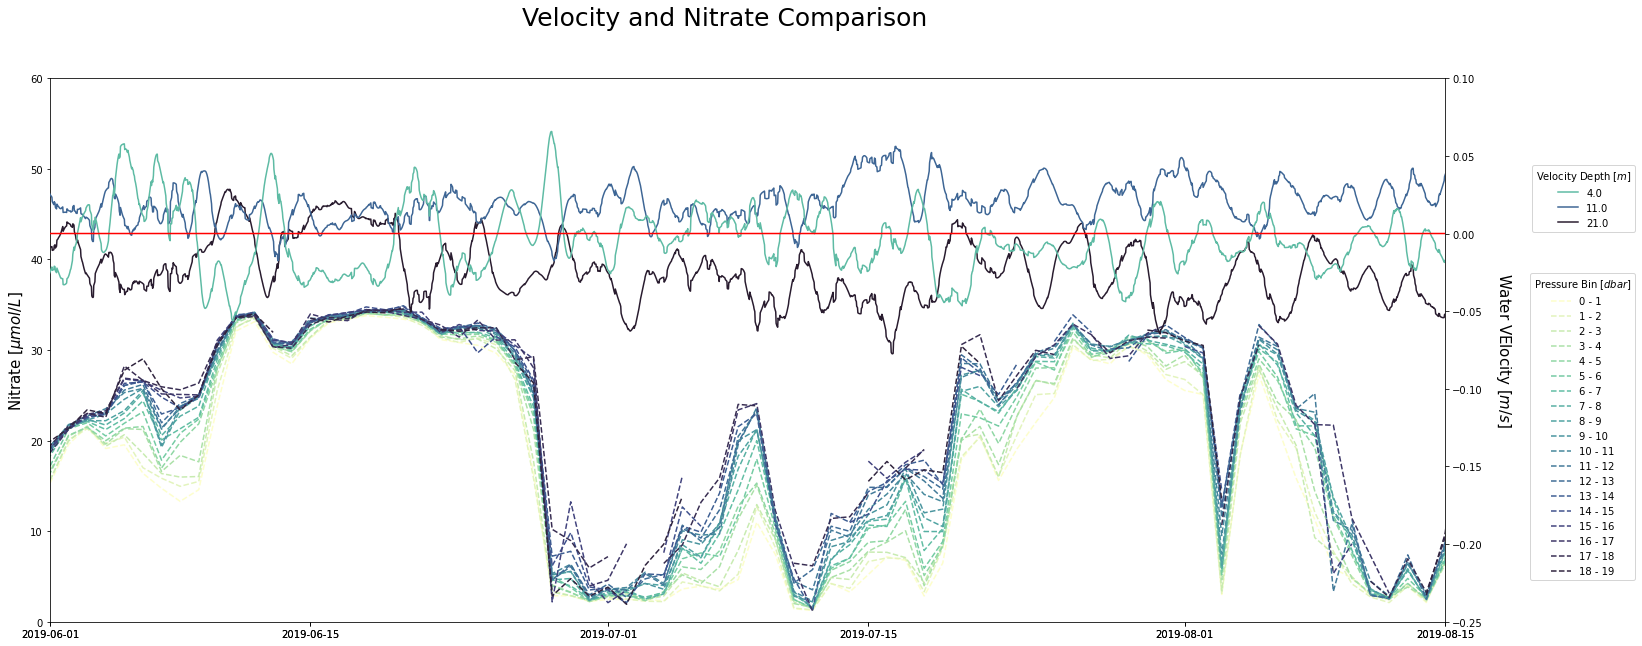

In [31]:
fig = plt.figure(figsize=(25,10))
fig.suptitle('Velocity and Nitrate Comparison', fontsize=25)
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Nitrate [$\mu mol/L$]", fontsize=15)
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.set_ylabel("Water VElocity [$m/s$]", rotation=270, labelpad=30, fontsize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

templine = []
nitrline = []

for i in range(len(nitrate_grid.T)):   
    nitrline.append('')
    nitrline[i], = ax1.plot(time_grid, nitrate_grid.T[i], color=deep(i/len(nitrate_grid.T)), 
                            linestyle='--', label='%i - %i' %(pressure_bins[i], pressure_bins[i+1]))
    
veloline1, = ax2.plot(ds_adcp['time'], ds_adcp['cs_bar'].T[1], color=deep(0.99),
                      label='%.1f' %(-ds_adcp['bin_depths_avg'].values[1]))
veloline2, = ax2.plot(ds_adcp['time'], ds_adcp['cs_bar'].T[11], color=deep(0.66),
                     label='%.1f' %(-ds_adcp['bin_depths_avg'].values[11]))
veloline3, = ax2.plot(ds_adcp['time'], ds_adcp['cs_bar'].T[18], color=deep(0.33),
                     label='%.1f' %(-ds_adcp['bin_depths_avg'].values[18]))
velozero, = ax2.plot(ds_adcp['time'], zeros, color='r')


handle = [veloline3, veloline2, veloline1]
lgd1 = plt.legend(handles=nitrline, title='Pressure Bin [$dbar$]', bbox_to_anchor=(1.14,.65), loc=1)
lgd2 = plt.legend(handles=handle, title='Velocity Depth [$m$]', bbox_to_anchor=(1.14,.85), loc=1)
fig.add_artist(lgd1, lgd2)
plt.xlim([t1,t2])
ax1.set_ylim([0,60])
ax2.set_ylim([-0.25,0.1])

<ipython-input-37-a503b55b19c9>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_grid,pressure_grid,temperature_grid.T, shading='auto')
<ipython-input-37-a503b55b19c9>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_grid,pressure_grid,nitrate_grid.T, shading='auto')


Text(0, 0.5, 'Velocity [$m/s$]')

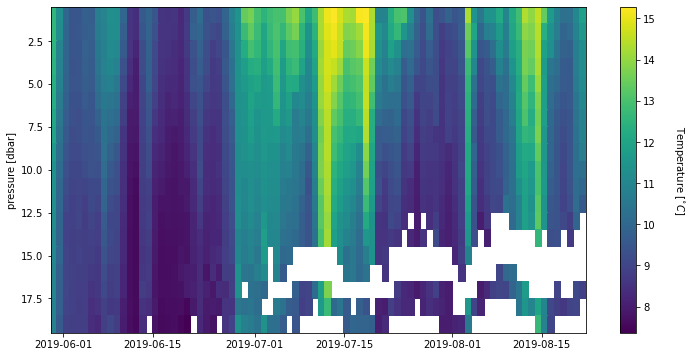

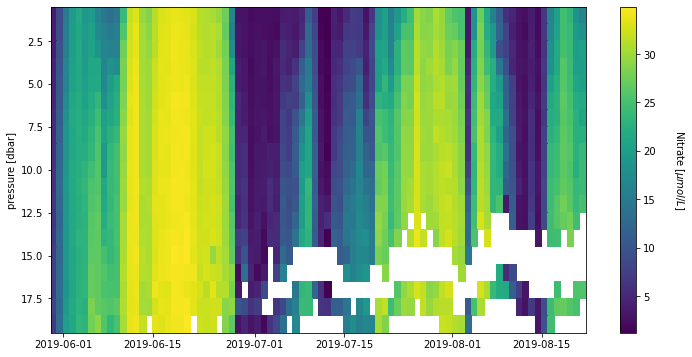

In [ ]:
plt.figure(figsize=(12,6))
plt.pcolor(time_grid,pressure_grid,temperature_grid.T, shading='auto')
plt.ylabel('pressure [dbar]')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('Temperature [$^{\circ}C$]', rotation=270, labelpad=30)

plt.figure(figsize=(12,6))
plt.pcolor(time_grid,pressure_grid,nitrate_grid.T, shading='auto')
plt.ylabel('pressure [dbar]')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('Nitrate [$\mu mol/L$]', rotation=270, labelpad=30)

plt.figure(figsize=(12,6))
plt.pcolor(ds_adcp['time'],ds_adcp['bin_height'],ds_adcp['cs_bar'].where(good).T, cmap='seismic', shading='auto')
plt.ylabel('Height Above Seafloor [$m$]')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Velocity [$m/s$]', rotation=270, labelpad=30)